In [1]:
# Importing necessary libraries for data manipulation, visualization, and clustering
import pandas as pd           # For data manipulation and analysis
import numpy as np           # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualization
from scipy.cluster.hierarchy import dendrogram, linkage  # For hierarchical clustering
from sklearn.cluster import AgglomerativeClustering     # For agglomerative clustering
from sklearn.preprocessing import MinMaxScaler          # For feature scaling
from sklearn.metrics import pairwise_distances, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from adjustText import adjust_text
import scipy.spatial           # For distance matrix calculations
import os                      # For file handling

In [2]:
"""
## Loading and Inspecting the Dataset
The dataset `cars_clus.csv` contains information about various car models, including
manufacturer, model, sales, price, and technical specifications like engine size and fuel efficiency.
"""

# Check if the file exists
file_path = 'cars_clus.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist. Please ensure it is in the correct directory.")

# Load the dataset
df = pd.read_csv(file_path)

# Display shape and first few rows
print(f'Shape of df: {df.shape}')
print("\nData types of columns:\n", df.dtypes)
df.head()

Shape of df: (159, 16)

Data types of columns:
 manufact      object
model         object
sales         object
resale        object
type          object
price         object
engine_s      object
horsepow      object
wheelbas      object
width         object
length        object
curb_wgt      object
fuel_cap      object
mpg           object
lnsales       object
partition    float64
dtype: object


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [3]:
df.isna().any()

manufact      True
model        False
sales        False
resale       False
type         False
price        False
engine_s     False
horsepow     False
wheelbas     False
width        False
length       False
curb_wgt     False
fuel_cap     False
mpg          False
lnsales      False
partition    False
dtype: bool

In [4]:
"""
## Checking for Missing Values
This step identifies columns with missing values to understand the data quality
before proceeding with cleaning and analysis.
"""

# Check for missing values
missing_values = df.isna().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")

Missing values in each column:
 manufact    2
dtype: int64


In [5]:
"""
## Data Cleaning
- Convert relevant columns to numeric, handling '$null$' values as NaN.
- Drop rows with missing values to ensure data quality.
- Calculate fuel efficiency in kilometers per liter (kml) using the conversion factor
  236.25 / mpg (derived from 1 mpg ≈ 0.425 km/L, so kml = 235.215 / mpg ≈ 236.25 / mpg for simplicity).
- Reset index after dropping rows.
"""

print(f'Shape of dataset before cleaning: {df.shape}')

# Replace '$null$' with NaN and convert columns to numeric
columns_to_numeric = ['sales', 'resale', 'type', 'price', 'engine_s', 'horsepow',
                      'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg', 'lnsales']
df[columns_to_numeric] = df[columns_to_numeric].replace('$null$', np.nan).apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Check for negative or illogical values
if (df[columns_to_numeric] < 0).any().any():
    print("Warning: Negative values detected in numeric columns. Please verify data integrity.")

# Calculate kilometers per liter (kml)
df['kml'] = 236.25 / df['mpg']

# Reset index
df = df.reset_index(drop=True)

print(f'Shape of dataset after cleaning: {df.shape}')
df.head()


Shape of dataset before cleaning: (159, 16)
Shape of dataset after cleaning: (117, 17)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,kml
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,8.437500
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,9.450000
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,10.738636
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,8.750000
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,10.738636


In [6]:
"""
## Feature Selection
Select numerical features relevant for clustering, focusing on car specifications
that influence performance and efficiency (engine size, horsepower, dimensions, weight, and fuel metrics).
"""

featureset = df[['engine_s', 'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg', 'kml']]

# Verify that selected features have valid values
if featureset.isna().any().any():
    raise ValueError("Selected features contain missing values after cleaning.")
if (featureset <= 0).any().any():
    print("Warning: Non-positive values detected in features. This may affect clustering results.")

In [7]:
"""
## Feature Normalization
Normalize features to [0, 1] range using MinMaxScaler to ensure all features contribute
equally to the clustering process, as they have different scales (e.g., horsepower vs. fuel capacity).
"""

# Convert features to numpy array and normalize
X = featureset.values
min_max_scaler = MinMaxScaler().fit(X)
feature_mtx = min_max_scaler.transform(X)

# Store normalized features in a DataFrame for clarity
feature_df = pd.DataFrame(feature_mtx, columns=featureset.columns)
feature_df.head()


,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,kml
0,0.114286,0.215190,0.186551,0.281437,0.306258,0.231056,0.133641,0.433333,0.303571
1,0.314286,0.430380,0.336226,0.461078,0.579228,0.503727,0.317972,0.333333,0.400000
2,0.357143,0.392405,0.477223,0.526946,0.628495,0.607143,0.354839,0.233333,0.522727
3,0.114286,0.240506,0.216920,0.335329,0.380826,0.342547,0.281106,0.400000,0.333333
4,0.257143,0.367089,0.349241,0.808383,0.567244,0.517391,0.377880,0.233333,0.522727


In [8]:
"""
## Distance Matrix Calculation
Compute the pairwise Euclidean distance matrix for normalized features using scipy's pdist
for efficiency, then convert to a square matrix. This is used for hierarchical clustering.
"""

from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances
dist_matrix = squareform(pdist(feature_mtx, metric='euclidean'))

# Verify distance matrix
if not np.allclose(dist_matrix, dist_matrix.T):
    raise ValueError("Distance matrix is not symmetric.")
if np.any(dist_matrix < 0):
    raise ValueError("Distance matrix contains negative values.")
dist_matrix

array([[0.        , 0.585763  , 0.78573911, ..., 0.28685109, 0.25672507,
        0.19866125],
       [0.585763  , 0.        , 0.25892304, ..., 0.36698373, 0.66436916,
        0.62297526],
       [0.78573911, 0.25892304, 0.        , ..., 0.55085974, 0.83285848,
        0.79502645],
       ...,
       [0.28685109, 0.36698373, 0.55085974, ..., 0.        , 0.41920634,
        0.35863999],
       [0.25672507, 0.66436916, 0.83285848, ..., 0.41920634, 0.        ,
        0.15212198],
       [0.19866125, 0.62297526, 0.79502645, ..., 0.35863999, 0.15212198,
        0.        ]])

89 [ 0.9596371  -0.80051695]
90 [ 0.71624031 -0.529464  ]
100 [ 0.63951983 -0.95032809]
101 [0.86839971 0.63868357]
103 [0.54312731 0.9383546 ]
104 [ 0.93476696 -0.70134049]
17 [ 0.70730443 -0.88392125]
92 [ 0.02767478 -0.98795986]
23 [-0.90499497 -0.10609375]
80 [ 0.25571657 -0.03588308]
21 [-0.98121634 -0.39128072]
81 [-0.2376862   0.32992459]
3 [0.48273987 0.05820469]
83 [ 0.1117181  -0.57138989]
102 [0.32466206 0.7820204 ]
18 [ 0.75767802 -0.05810978]
24 [ 0.57411338 -0.8022273 ]
19 [-0.30253893  0.97476743]
25 [0.06004752 0.58252985]
13 [-0.84637554 -0.83412491]
33 [-0.75904996 -0.82510423]
68 [ 0.16462914 -0.34191919]
74 [0.61308716 0.6113745 ]
7 [-0.02338222  0.79928779]
14 [ 0.05887413 -0.55568745]
84 [0.79587285 0.40812139]
16 [0.0571795  0.37107973]
85 [0.68358488 0.17179649]
4 [-0.39242559 -0.81485214]
11 [0.80113781 0.58600669]
35 [0.79199181 0.18935091]
66 [ 0.13826231 -0.28355465]
9 [-0.67624674 -0.11154875]
87 [ 0.20525074 -0.88404774]
45 [-0.67106615  0.89643125]
53 [ 0

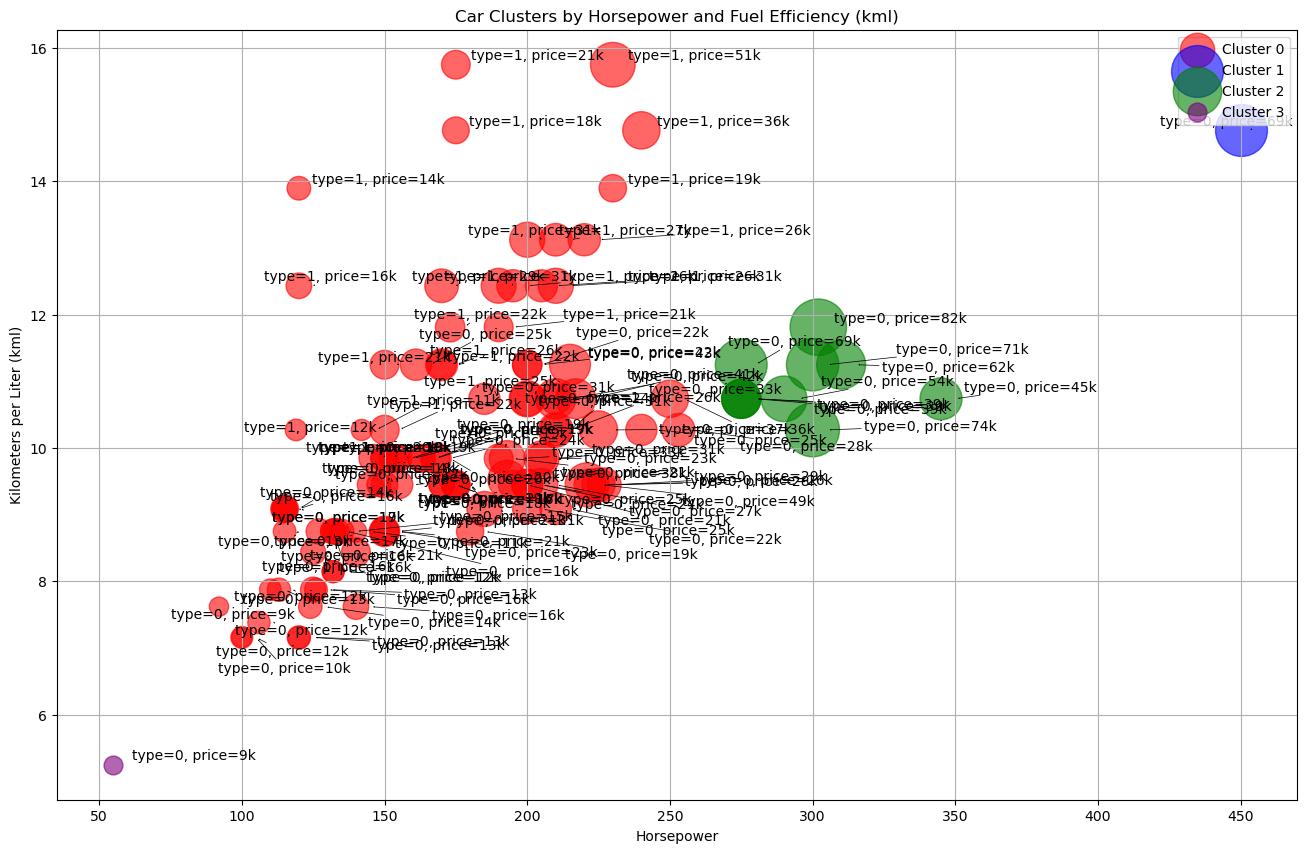

C:\Users\AERO\AppData\Local\Temp\ipykernel_9476\1578904267.py:42: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='average')  # Compute the linkage matrix for hierarchical clustering


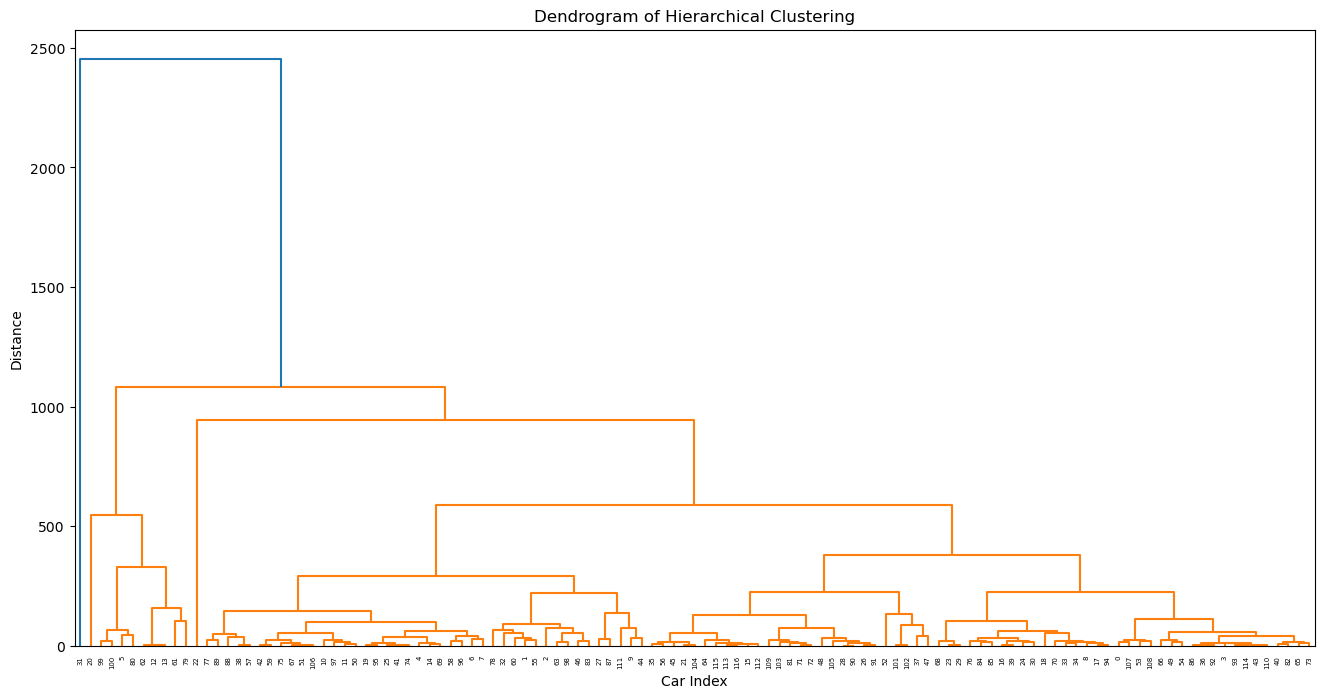

Silhouette Score: 0.4314905323265023
Calinski-Harabasz Score: 52.62796474185208
Davies-Bouldin Score: 0.33679616036387106


In [9]:
# Step 1: Compute the distance matrix (Euclidean distance) between data points
# The distance matrix is essential for hierarchical clustering
dist_matrix = pairwise_distances(df[['horsepow', 'kml', 'price']], metric='euclidean')

# Step 2: Perform hierarchical clustering using the Agglomerative Clustering algorithm
n_clusters = 4  # Define the number of clusters
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')  # 'average' linkage method
cluster_labels = clustering.fit_predict(df[['horsepow', 'kml', 'price']])  # Cluster the data using raw features

# Step 3: Define colors for visualizing clusters
colors = ['red', 'blue', 'green', 'purple'][:n_clusters]

# Step 4: Create a DataFrame for plotting, adding cluster labels to the data
agg_cars = df[['horsepow', 'kml', 'price']].copy()
agg_cars['cluster'] = cluster_labels  # Add cluster labels to the DataFrame

# Step 5: Plot the scatter plot of the clustered data
plt.figure(figsize=(16, 10))
texts = []  # List to hold text labels for each point
for color, label in zip(colors, range(n_clusters)):
    subset = agg_cars[agg_cars.cluster == label]  # Filter data points for each cluster
    # Scatter plot with bubble sizes determined by the price of the car
    plt.scatter(subset.horsepow, subset.kml, s=subset.price*20, c=color, label=f'Cluster {label}', alpha=0.6)
    # Add labels to each point (with adjustments to avoid overlap)
    for i in subset.index:
        texts.append(plt.text(subset.loc[i, 'horsepow']+5, subset.loc[i, 'kml'], 
                             f'type={int(df.loc[i, "type"])}, price={int(subset.loc[i, "price"])}k'))

# Adjust text labels to avoid overlap using the adjustText library
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Display the legend, title, and axes labels
plt.legend()
plt.title('Car Clusters by Horsepower and Fuel Efficiency (kml)')
plt.xlabel('Horsepower')
plt.ylabel('Kilometers per Liter (kml)')
plt.grid(True)
plt.show()

# Step 6: Plot the dendrogram to visualize the hierarchical clustering structure
plt.figure(figsize=(16, 8))
Z = linkage(dist_matrix, method='average')  # Compute the linkage matrix for hierarchical clustering
dendrogram(Z, labels=df.index, leaf_rotation=90)  # Plot the dendrogram with car index labels
plt.title('Dendrogram of Hierarchical Clustering')
plt.xlabel('Car Index')
plt.ylabel('Distance')
plt.show()

# Step 7: Compute evaluation metrics to assess the clustering quality

# Silhouette Score: Measures how similar a sample is to its own cluster compared to other clusters
score = silhouette_score(df[['horsepow', 'kml', 'price']], cluster_labels)
print(f'Silhouette Score: {score}')  # A higher score indicates better clustering quality

# Calinski-Harabasz Score: Measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion
ch_score = calinski_harabasz_score(df[['horsepow', 'kml', 'price']], cluster_labels)
print(f'Calinski-Harabasz Score: {ch_score}')  # Higher values indicate better clustering

# Davies-Bouldin Score: Measures the average similarity ratio of each cluster with the cluster that is most similar to it
db_score = davies_bouldin_score(df[['horsepow', 'kml', 'price']], cluster_labels)
print(f'Davies-Bouldin Score: {db_score}')  # Lower values indicate better clustering

# The same model, but in a different and slightly varied way

In [13]:
Z_using_dist_matrix = linkage(dist_matrix, 'average')
Z_using_dist_matrix

C:\Users\AERO\AppData\Local\Temp\ipykernel_9476\954890186.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_using_dist_matrix = linkage(dist_matrix, 'average')


array([[2.80000000e+01, 9.00000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 7.35078317e-01, 2.00000000e+00],
       [2.60000000e+01, 9.10000000e+01, 1.23087869e+00, 2.00000000e+00],
       [7.10000000e+01, 7.20000000e+01, 1.27167428e+00, 2.00000000e+00],
       [9.30000000e+01, 1.14000000e+02, 1.50917166e+00, 2.00000000e+00],
       [4.10000000e+01, 7.40000000e+01, 1.73837630e+00, 2.00000000e+00],
       [1.60000000e+01, 3.90000000e+01, 2.03720925e+00, 2.00000000e+00],
       [6.20000000e+01, 1.18000000e+02, 2.17454816e+00, 3.00000000e+00],
       [2.10000000e+01, 1.04000000e+02, 2.45876306e+00, 2.00000000e+00],
       [2.30000000e+01, 2.90000000e+01, 2.50387895e+00, 2.00000000e+00],
       [1.13000000e+02, 1.16000000e+02, 2.56237836e+00, 2.00000000e+00],
       [3.60000000e+01, 9.20000000e+01, 2.61163469e+00, 2.00000000e+00],
       [1.70000000e+01, 9.40000000e+01, 3.02093005e+00, 2.00000000e+00],
       [5.10000000e+01, 1.06000000e+02, 3.20379245e

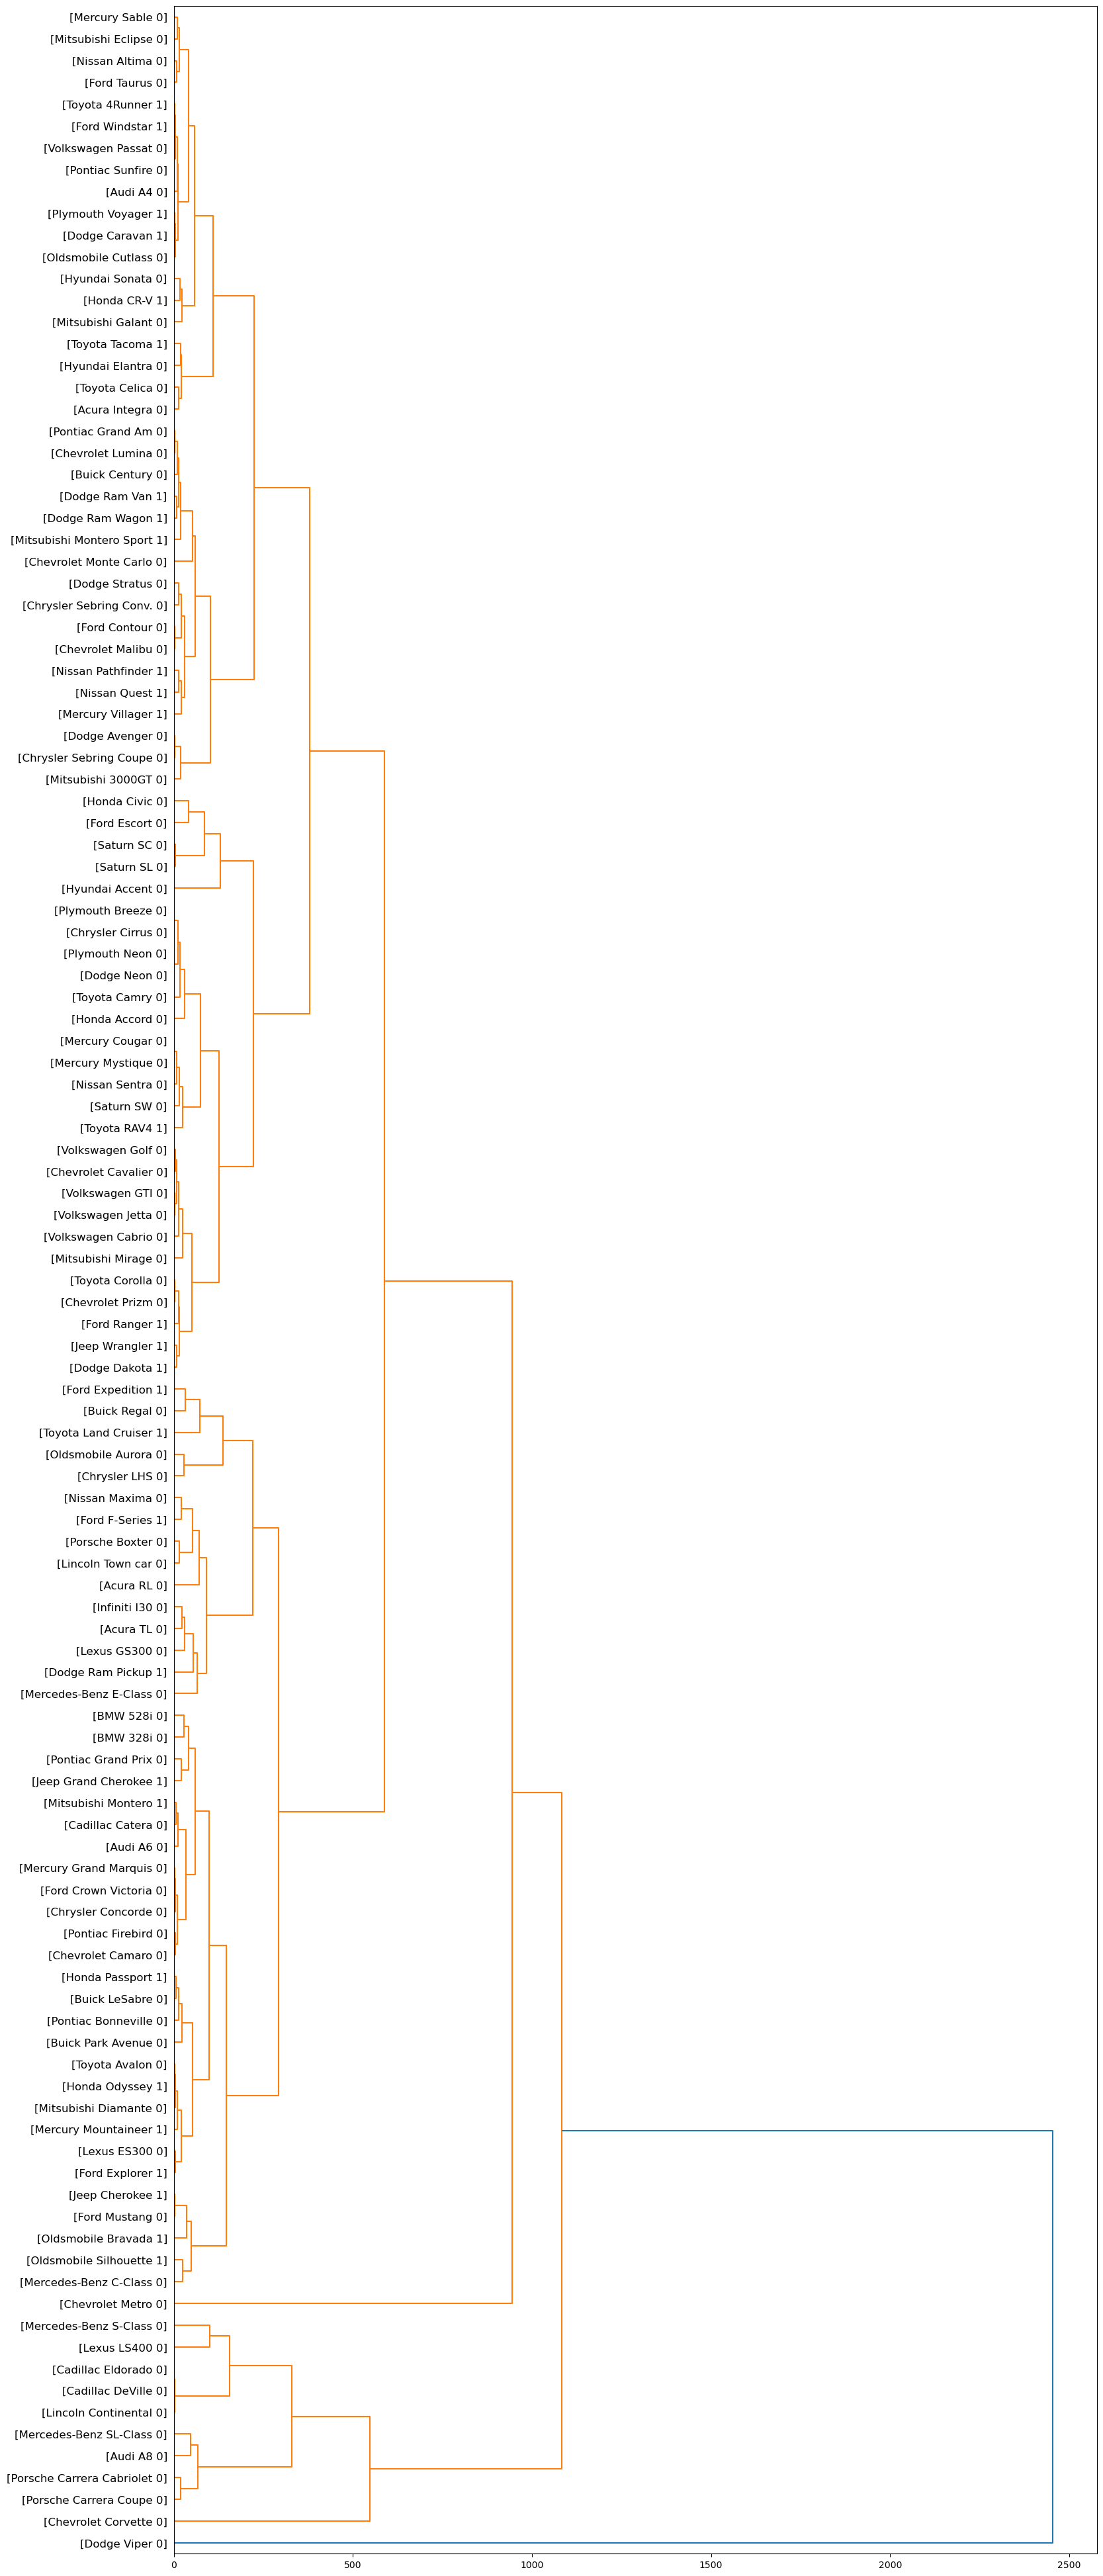

In [14]:
fig = plt.figure(figsize=(18,50))
def ill(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])) )
dendro=dendrogram (Z_using_dist_matrix,  leaf_label_func=ill, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [15]:
clustering = AgglomerativeClustering(n_clusters=8, linkage = 'average')
clustering.fit(dist_matrix)
clustering.labels_

c:\ProgramData\anaconda3\envs\ai\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([2, 0, 0, 2, 0, 3, 0, 0, 2, 0, 0, 0, 1, 1, 0, 6, 2, 2, 2, 0, 5, 6,
       7, 2, 2, 0, 6, 0, 6, 2, 2, 4, 0, 2, 2, 6, 2, 6, 0, 2, 2, 0, 0, 2,
       0, 6, 0, 6, 6, 2, 0, 0, 6, 2, 2, 0, 6, 0, 0, 0, 0, 1, 1, 0, 6, 2,
       2, 0, 2, 0, 2, 6, 6, 2, 0, 0, 2, 0, 0, 1, 3, 6, 2, 0, 2, 2, 2, 0,
       0, 0, 6, 6, 2, 2, 2, 0, 0, 0, 0, 3, 3, 6, 6, 6, 6, 6, 0, 2, 2, 6,
       2, 0, 6, 6, 2, 6, 6], dtype=int64)

In [16]:
df['cluster_'] = clustering.labels_
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,kml,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,8.437500,2
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,9.450000,0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,10.738636,0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,8.750000,2
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,10.738636,0


C:\Users\AERO\AppData\Local\Temp\ipykernel_9476\3771366663.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)


Text(0, 0.5, 'mpg')

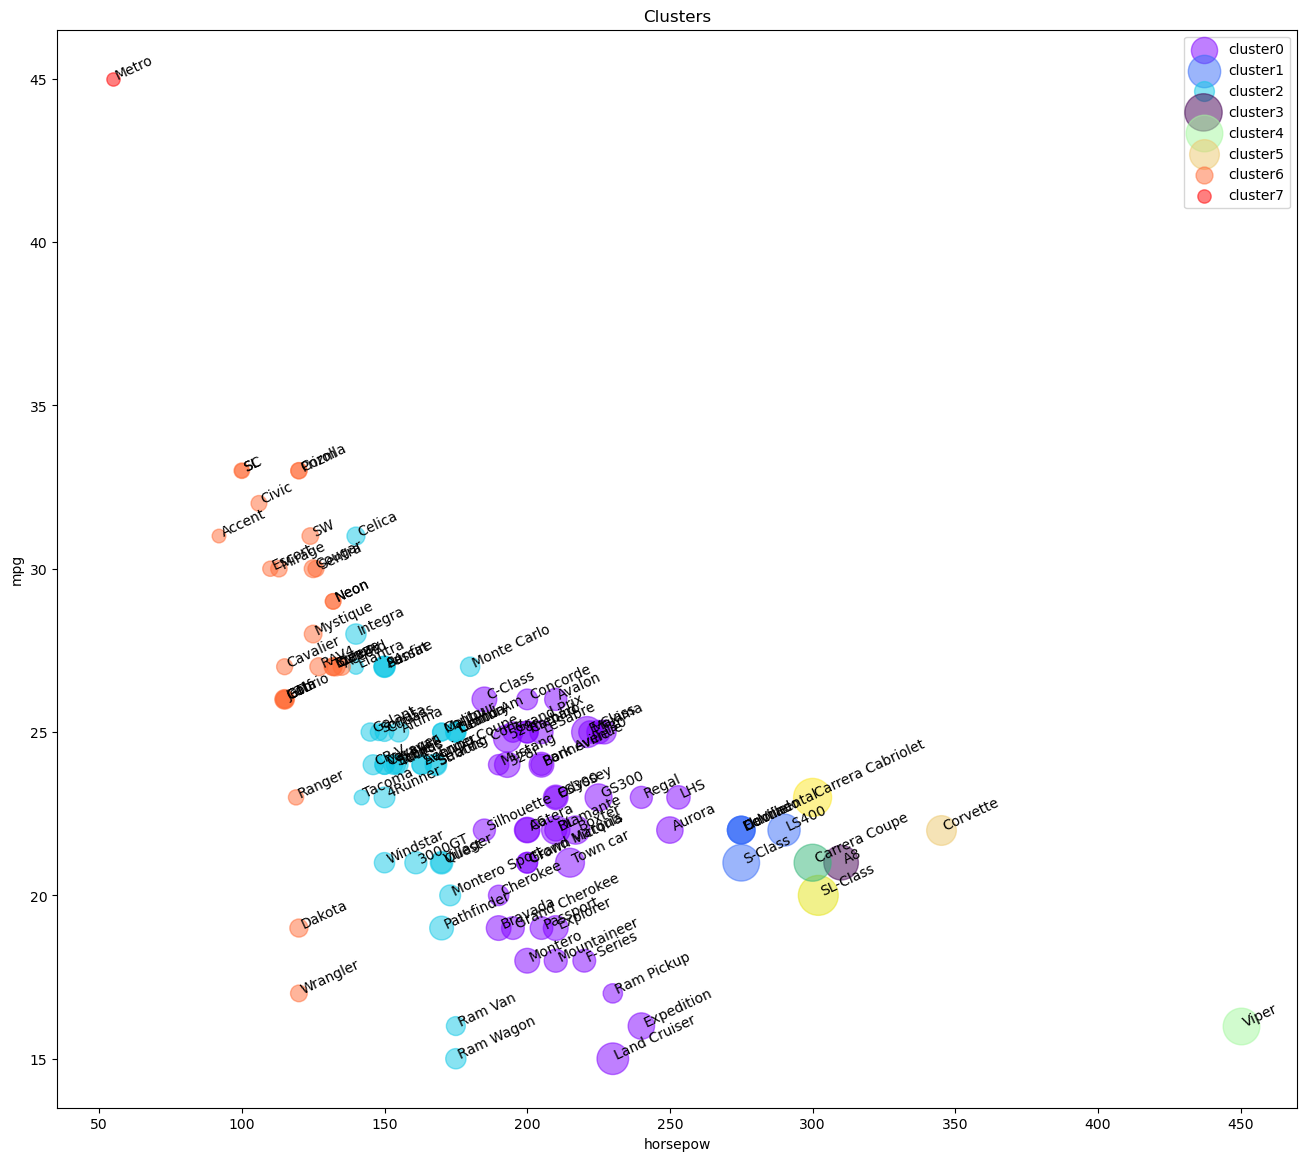

In [17]:
import matplotlib.cm as cm
n_clusters = max(clustering.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df[df.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

In [18]:
df.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type
0         0.0     29
          1.0     13
1         0.0      5
2         0.0     24
          1.0     12
3         0.0      4
4         0.0      1
5         0.0      1
6         0.0     23
          1.0      4
7         0.0      1
Name: cluster_, dtype: int64

In [19]:
agg_cars = df.groupby(['cluster_','type'])[['horsepow','engine_s','kml','price']].mean()
agg_cars

horsepow  engine_s        kml      price
cluster_ type                                            
0        0.0   210.551724  3.420690  10.035503  30.449310
         1.0   208.846154  4.076923  12.795954  29.508692
1        0.0   278.000000  4.420000  10.840909  48.469000
2        0.0   158.250000  2.579167   9.375613  19.434875
         1.0   160.083333  2.966667  11.548922  21.234667
3        0.0   303.000000  4.000000  11.146060  72.647500
4        0.0   450.000000  8.000000  14.765625  69.725000
5        0.0   345.000000  5.700000  10.738636  45.705000
6        0.0   118.782609  1.943478   8.155994  14.458957
         1.0   121.500000  2.375000  11.338252  15.094500
7        0.0    55.000000  1.000000   5.250000   9.235000

C:\Users\AERO\AppData\Local\Temp\ipykernel_9476\3464120307.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
C:\Users\AERO\AppData\Local\Temp\ipykernel_9476\3464120307.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset.horsepow, subset.kml, s=subset.price*20, c=color, label='cluster'+str(label))


Text(0, 0.5, 'kml')

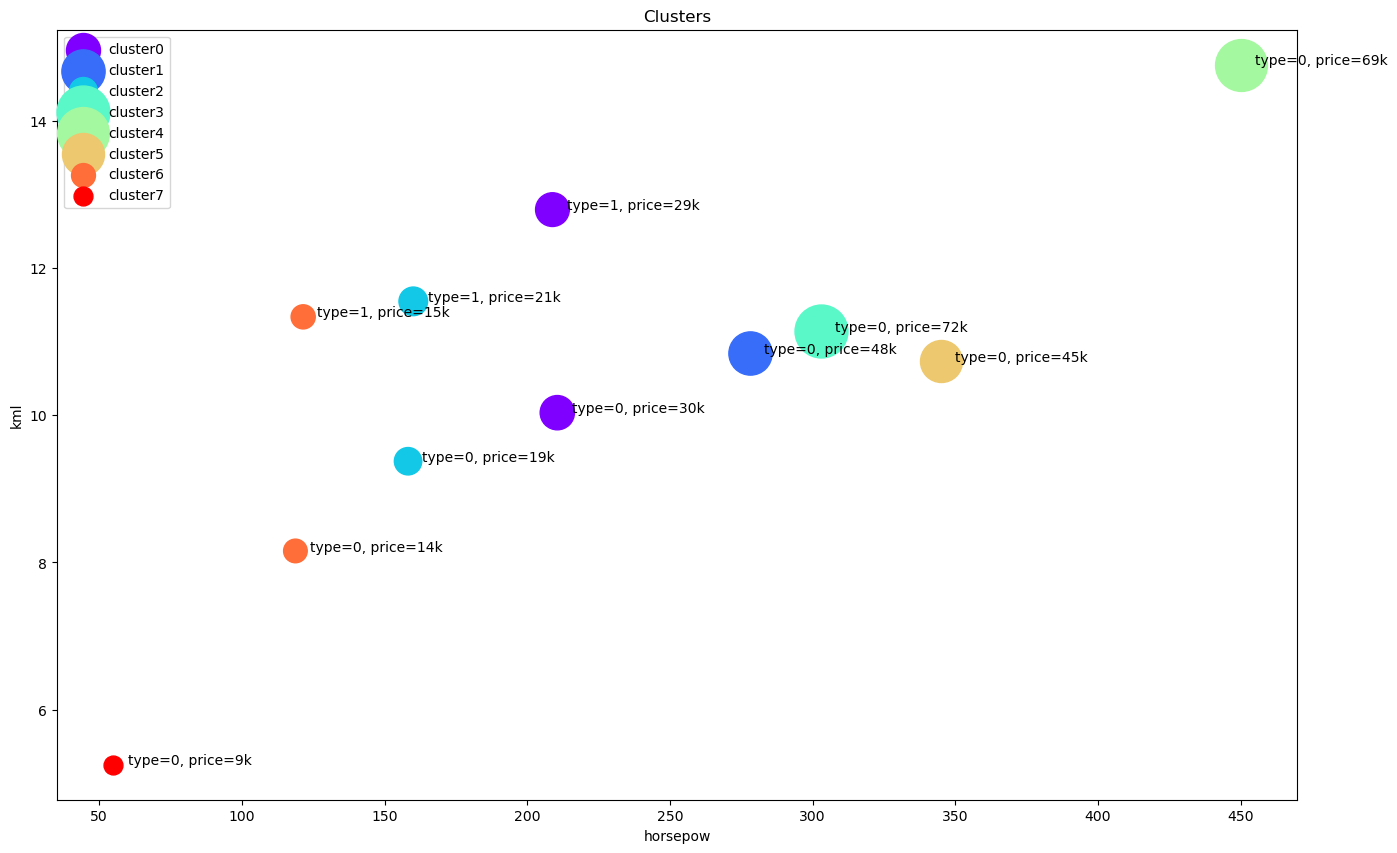

In [20]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.kml, s=subset.price*20, c=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('kml')
